In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")
import clickhouse_connect  


sys.path.append('/Users/kemran/Desktop/work_files/python_files') 
from credential import postgres_secret,clickhouse_dwh_secret

def get_engine(user):
    if user == postgres_secret['user']:
        db_name = postgres_secret['db_name']
        password = postgres_secret['password']
        host = postgres_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:6432/{db_name}')
    elif user == clickhouse_dwh_secret['user']:
            db_name = clickhouse_dwh_secret['db_name'] 
            password = clickhouse_dwh_secret['password']
            host = clickhouse_dwh_secret['host']
            engine = create_engine(f'clickhouse://{user}:{password}@{host}:8123/{db_name}')
    return engine
    
connection_clickhouse = clickhouse_connect.get_client(
    host = clickhouse_dwh_secret['host'],
    port= '8123',
    username = clickhouse_dwh_secret['user'],
    password = clickhouse_dwh_secret['password'],
    database='datamarts'
    )

    
def execute(SQL, user):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(user)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = round(end_time - start_time,4) # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    print()
    return df

In [2]:
query =f'''
                WITH t1 AS (SELECT
                            date,
                            date_trunc('week',date) as week_date,
                            profile_id,
                            free_days,
                            JSONExtractInt(payload,'duration') AS duration,
                            created_at::date AS trial_start,
                            JSONExtractString(payload,'item_type') AS item_type,
                            JSONExtractString(payload,'item_title') AS item_title,
                            CASE WHEN first_prolong_date!='1970-01-01' 
                                    AND date>=first_prolong_date 
                                    AND ends_at>=date THEN 'subs'
                                 WHEN date>=trial_start 
                                    AND ends_at>=date (first_prolong_date='1970-01-01' OR first_prolong_date>date) THEN 'trial'
                                 WHEN date>=reg_date 
                                    AND (trial_start='1970-01-01' OR trial_start>date) THEN 'reg'
                            END AS user_type,
                            CASE WHEN event_name IN ('auto_player_streaming','auto_kinom_streaming') 
                                   AND event_page<>'tvchannel' 
                                   AND JSONExtractInt(payload,'viewing_time')<= JSONExtractInt(payload,'duration')
                                 THEN JSONExtractInt(payload,'viewing_time')
                                 WHEN event_name IN ('auto_player_streaming','auto_kinom_streaming') 
                                   AND event_page='tvchannel' 
                                   AND JSONExtractInt(payload,'viewing_time') <18000
                                 THEN JSONExtractInt(payload,'viewing_time')
                            END AS viewing_time
                            FROM datamarts.clean_event 
                            WHERE date BETWEEN '2025-06-30' AND '2025-07-20'
                            AND reg_date!='1970-01-01' 
                            AND client_type!='backend'
                            )
                    
                SELECT date,week_date,profile_id,free_days,item_type,item_title,user_type,COALESCE(sum(viewing_time),0) AS watchtime
                FROM t1
                WHERE item_type='series'
                GROUP BY 1,2,3,4,5,6,7
                HAVING watchtime>0
                    '''
df = execute(query,user='kmekhtiev')
df['date'] = pd.to_datetime(df['date'])
df['week_date'] = pd.to_datetime(df['week_date'])

Время выполнения функции: 4.6841 секунд



In [3]:
#df['week_date'] = df['date'].dt.to_period('W').dt.start_time

In [4]:
df_filter = df[(df['user_type']=='trial')] # Оставляем только триал

df_filter['date_week2'] = df_filter['date'].apply(lambda x:'июль' if pd.Timestamp('2025-06-30') <= x < pd.Timestamp('2025-07-20')  else 'июль')
df_agg = df_filter.groupby(['week_date','item_title'],as_index=False).agg(watchtime =('watchtime','sum'), cnt_user =('profile_id','nunique'))
df_agg['watchtime_per_user'] = df_agg['watchtime']/df_agg['cnt_user']



median = df_filter.groupby(['week_date','item_title'])['watchtime'].median().reset_index()

median.rename(columns={'watchtime':'median'},inplace=True)

df_merge = pd.merge(df_agg,median,how='left',on=['week_date','item_title'])
df_merge[['watchtime_per_user','median']] = df_merge[['watchtime_per_user','median']]/60

In [5]:
df_filter

,date,week_date,profile_id,free_days,item_type,item_title,user_type,watchtime,date_week2
1,2025-07-17,2025-07-14,965eca69-6923-4135-b2c8-b69c04f36a7a,35,series,Клон,trial,85,июль
3,2025-07-19,2025-07-14,f4e9322b-7329-4242-ad8e-681b0c8d8bdd,35,series,Великолепные Медичи,trial,9,июль
4,2025-07-13,2025-07-07,bf09be22-2c3a-49f0-b502-798764cd56bb,14,series,Библиотекари,trial,7808,июль
5,2025-07-07,2025-07-07,0698f7bd-6f77-4d30-868f-7495ed033145,14,series,Клон,trial,16984,июль
6,2025-07-17,2025-07-14,61d3db0e-4aa6-4fe6-b09b-3cab6e9d10b6,14,series,Любовь напрокат,trial,34126,июль
...,...,...,...,...,...,...,...,...,...
11034,2025-07-20,2025-07-14,8272053b-d31d-4a46-80c1-46c16be0699b,14,series,Библиотекари: Следующая глава,trial,10170,июль
11035,2025-07-04,2025-06-30,00144b53-47e9-481b-9638-93c5e8c609f2,30,series,Любовь напрокат,trial,4948,июль
11038,2025-07-01,2025-06-30,b3f5a03e-a1cd-40ae-ad57-86f0e0dba66c,35,series,Библиотекари,trial,12149,июль
11039,2025-07-16,2025-07-14,4b71e491-ff99-42ab-85a1-5fd4583a7452,14,series,Любовь напрокат,trial,3831,июль


In [6]:
df_merge[df_merge['week_date']=='2025-07-14'].sort_values(by='cnt_user').tail(10)

,week_date,item_title,watchtime,cnt_user,watchtime_per_user,median
545,2025-07-14,Магнат,65892,13,84.476923,10.300000
489,2025-07-14,Дороги Индии,277054,15,307.837778,66.658333
597,2025-07-14,Порочный,73052,15,81.168889,20.558333
557,2025-07-14,Мисс Остин,81268,21,64.498413,32.716667
539,2025-07-14,Любовь Мерьем,768217,30,426.787222,125.533333
459,2025-07-14,Великолепные Медичи,452495,58,130.027299,38.591667
451,2025-07-14,Библиотекари,1693805,87,324.483716,103.866667
541,2025-07-14,Любовь напрокат,5456810,131,694.250636,126.591667
525,2025-07-14,Клон,6444558,169,635.557988,128.250000
452,2025-07-14,Библиотекари: Следующая глава,2548042,349,121.682999,42.633333


In [7]:
df_merge['week_date'].unique()

<DatetimeArray>
['2025-06-30 00:00:00', '2025-07-07 00:00:00', '2025-07-14 00:00:00']
Length: 3, dtype: datetime64[ns]

In [23]:
df_isin = df_merge[df_merge['item_title'].isin(['Великолепные Медичи','Любовь напрокат','Клон','Библиотекари: Следующая глава','Библиотекари'])]
#df_isin['week_date'] = df_isin['week_date'].astype('str')

# df_isin['week_date_new'] = df_isin['week_date'].apply(
#                             lambda x: '3 недели назад' if x == '2025-03-17'
#                                        else '2 недели назад' if x == '2025-03-24'
#                                        else 'прошлая неделя'if x == '2025-03-31'
#                                        else x
#                             )

In [25]:
df_isin

,week_date,item_title,watchtime,cnt_user,watchtime_per_user,median
14,2025-06-30,Библиотекари,403537,31,216.955376,70.833333
15,2025-06-30,Библиотекари: Следующая глава,735131,159,77.057757,33.383333
22,2025-06-30,Великолепные Медичи,160973,22,121.949242,14.950000
83,2025-06-30,Клон,6602901,192,573.168490,114.250000
102,2025-06-30,Любовь напрокат,1320895,33,667.118687,152.800000
235,2025-07-07,Библиотекари,659391,49,224.282653,81.250000
236,2025-07-07,Библиотекари: Следующая глава,1197111,220,90.690227,31.875000
246,2025-07-07,Великолепные Медичи,628986,75,139.774667,44.875000
295,2025-07-07,Клон,6643554,165,671.066061,124.758333
312,2025-07-07,Любовь напрокат,1039415,28,618.699405,173.966667


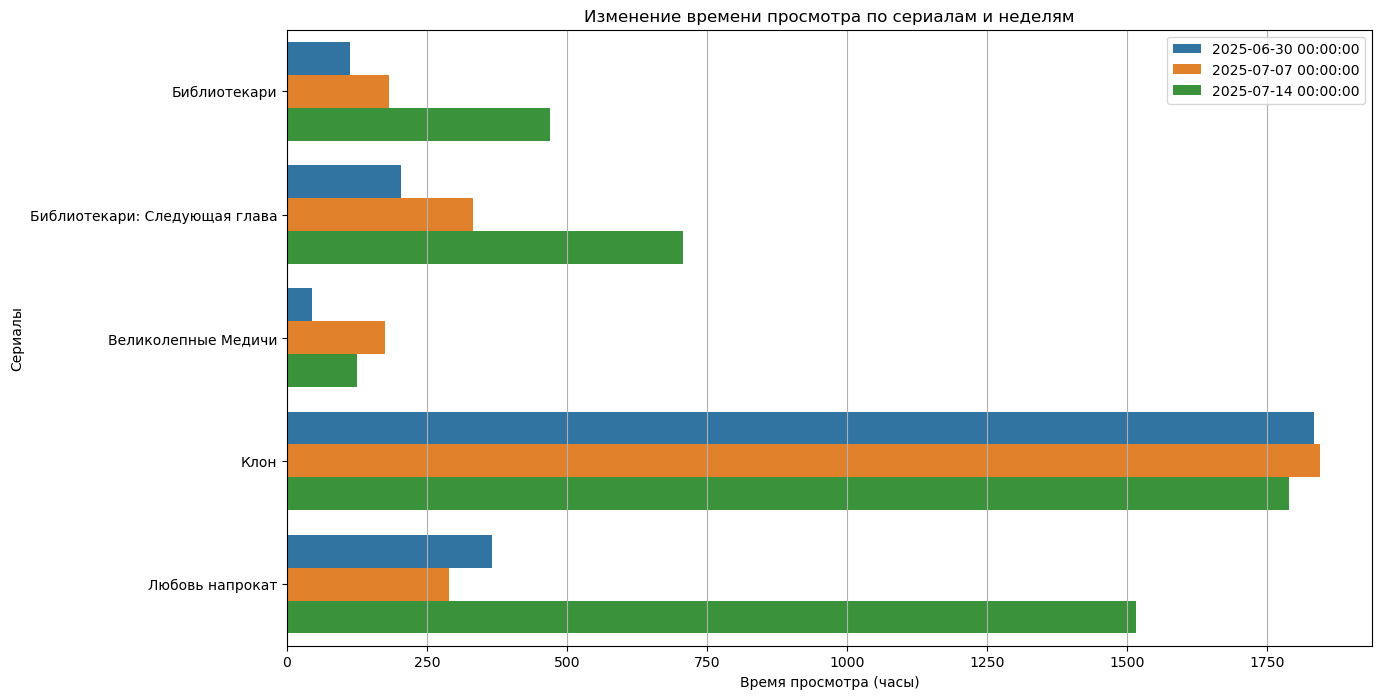

In [27]:
plt.figure(figsize=(14,8))
df_isin['watchtime'] = df_isin['watchtime']/3600
sns.barplot(data=df_isin, x='watchtime', y='item_title', hue='week_date', orient='h')  

# Настройка графика  
plt.title('Изменение времени просмотра по сериалам и неделям')  
plt.xlabel('Время просмотра (часы)')  
plt.ylabel('Сериалы')  
plt.legend(title = '')
plt.grid(axis='x')  

In [21]:
plt.figure(figsize=(14,8))

sns.barplot(data=df_isin, x='median', y='item_title', hue='week_date_new', orient='h')  

# Настройка графика  
plt.title('Изменение времени просмотра по сериалам и неделям')  
plt.xlabel('Время просмотра (минуты)')  
plt.ylabel('Сериалы')  
plt.legend(title='')  
plt.grid(axis='x')  

NameError: name 'df_isin' is not defined

<Figure size 1400x800 with 0 Axes>

# Посмотрим просмотры по подписчикам 

In [ ]:
query =f'''
                WITH t1 AS (SELECT
                            date,
                            date_trunc('week',date) as week_date,
                            profile_id,
                            JSONExtractInt(payload,'duration') AS duration,
                            created_at::date AS trial_start,
                            JSONExtractString(payload,'item_type') AS item_type,
                            JSONExtractString(payload,'item_title') AS item_title,
                            CASE WHEN first_prolong_date!='1970-01-01' 
                                    AND date>=first_prolong_date 
                                    AND ends_at>=date THEN 'subs'
                                 WHEN date>=trial_start 
                                    AND ends_at>=date (first_prolong_date='1970-01-01' OR first_prolong_date>date) THEN 'trial'
                                 WHEN date>=reg_date 
                                    AND (trial_start='1970-01-01' OR trial_start>date) THEN 'reg'
                            END AS user_type,
                            CASE WHEN event_name IN ('auto_player_streaming','auto_kinom_streaming') 
                                   AND event_page<>'tvchannel' 
                                   AND JSONExtractInt(payload,'viewing_time')<= JSONExtractInt(payload,'duration')
                                 THEN JSONExtractInt(payload,'viewing_time')
                                 WHEN event_name IN ('auto_player_streaming','auto_kinom_streaming') 
                                   AND event_page='tvchannel' 
                                   AND JSONExtractInt(payload,'viewing_time') <18000
                                 THEN JSONExtractInt(payload,'viewing_time')
                            END AS viewing_time
                            FROM datamarts.sandbox_data_distr
                            WHERE date BETWEEN '2024-12-02' AND '2024-12-22'
                            AND reg_date!='1970-01-01' 
                            AND client_type!='backend'
                            )
                    
                SELECT date,week_date,profile_id,item_type,item_title,user_type,COALESCE(sum(viewing_time),0) AS watchtime
                FROM t1
                WHERE item_type='series'
                GROUP BY 1,2,3,4,5,6
                HAVING watchtime>0
                    '''
df = execute(query,user='kmekhtiev')
df['date'] = pd.to_datetime(df['date'])
df['week_date'] = pd.to_datetime(df['week_date'])

In [ ]:
df.groupby(['week_date','user_type'])['profile_id'].nunique()

In [ ]:
df = df[df['user_type']=='subs'] # Оставляем только подписчиков
df_agg = df.groupby(['week_date','item_title'],as_index=False).agg(watchtime =('watchtime','sum'), cnt_user =('profile_id','nunique'))
df_agg['watchtime_per_user'] = df_agg['watchtime']/df_agg['cnt_user']
median = df.groupby(['week_date','item_title'])['watchtime'].median().reset_index()

median.rename(columns={'watchtime':'median'},inplace=True)

df_merge = pd.merge(df_agg,median,how='left',on=['week_date','item_title'])
df_merge[['watchtime_per_user','median']] = df_merge[['watchtime_per_user','median']]/60

In [ ]:
df_merge[df_merge['week_date']=='2024-12-16'].sort_values(by='cnt_user').tail(10)

In [ ]:
df_isin = df_merge[df_merge['item_title'].isin(['Билет в один конец','Любовь Мерьем','Любовь напрокат','Какао','Убийство по Фрейду'])]
df_isin['week_date'] = df_isin['week_date'].astype('str')
df_isin['week_date_new'] = df_isin['week_date'].apply(
                            lambda x: '1-ая неделя декабря' if x == '2024-12-02'
                                       else '2-ая неделя декабря' if x == '2024-12-09'
                                       else '3-ая неделя декабря'if x == '2024-12-16'
                                       else x
                            )

In [ ]:
plt.figure(figsize=(14,8))

sns.barplot(data=df_isin, x='watchtime_per_user', y='item_title', hue='week_date_new', orient='h')  

# Настройка графика  
plt.title('Изменение времени смотрения сериалов по неделям на пользователя (подписчики)')  
plt.xlabel('Время просмотра (минуты)')  
plt.ylabel('Сериалы')  
plt.legend(title='')  
plt.grid(axis='x')  

In [ ]:
query = f'''
         WITH t1 AS (SELECT
                            date,
                            date_trunc('week',date) as week_date,
                            payload,
                            profile_id,
                            free_days,
                            client_type,
                            JSONExtractInt(payload,'duration') AS duration,
                            created_at::date AS trial_start,
                            JSONExtractString(payload,'item_type') AS item_type,
                            JSONExtractString(payload,'item_title') AS item_title,
                            JSONExtractString(payload,'channel_title') AS channel_title,
                            CASE WHEN first_prolong_date!='1970-01-01' 
                                    AND date>=first_prolong_date 
                                    AND ends_at>=date THEN 'subs'
                                 WHEN date>=trial_start 
                                    AND ends_at>=date (first_prolong_date='1970-01-01' OR first_prolong_date>date) THEN 'trial'
                                 WHEN date>=reg_date 
                                    AND (trial_start='1970-01-01' OR trial_start>date) THEN 'reg'
                            END AS user_type,
                            CASE WHEN event_name IN ('auto_player_streaming','auto_kinom_streaming') 
                                   AND event_page<>'tvchannel' 
                                   AND JSONExtractInt(payload,'viewing_time')<= JSONExtractInt(payload,'duration')
                                 THEN JSONExtractInt(payload,'viewing_time')
                                 WHEN event_name IN ('auto_player_streaming','auto_kinom_streaming') 
                                   AND event_page='tvchannel' 
                                   AND JSONExtractInt(payload,'viewing_time') <18000
                                 THEN JSONExtractInt(payload,'viewing_time')
                            END AS viewing_time
                            FROM datamarts.clean_event 
                            WHERE date BETWEEN '2025-03-12' AND '2025-04-21'
                            AND reg_date!='1970-01-01' 
                            AND client_type!='backend'
                            )
                    
                SELECT date,week_date,profile_id,free_days,item_type,item_title,
                channel_title,
                CASE WHEN channel_title='' THEN item_title ELSE channel_title END channel_title_all,
                user_type,COALESCE(sum(viewing_time),0) AS watchtime
                FROM t1
                WHERE item_type='tvchannel' AND channel_title_all!=''
                GROUP BY 1,2,3,4,5,6,7,8,9
                HAVING watchtime>0
                    '''
df = execute(query,user='kmekhtiev')
df['date'] = pd.to_datetime(df['date'])
df['week_date'] = pd.to_datetime(df['week_date'])

In [ ]:
df['period'] = df['date'].apply(lambda x:'март' if pd.Timestamp('2025-03-12') <= x < pd.Timestamp('2025-04-01')  else 'апрель')

In [ ]:
df_filter = df[(df['user_type']=='trial')] # & (~df['free_days'].isin([3,14]))] # Оставляем только триал


df_agg = df_filter.groupby(['period','channel_title_all'],as_index=False).agg(watchtime =('watchtime','sum'), cnt_user =('profile_id','nunique'))
df_agg['watchtime_per_user'] = df_agg['watchtime']/df_agg['cnt_user']



median = df_filter.groupby(['period','channel_title_all'])['watchtime'].median().reset_index()

median.rename(columns={'watchtime':'median'},inplace=True)

df_merge = pd.merge(df_agg,median,how='left',on=['period','channel_title_all'])
df_merge[['watchtime_per_user','median']] = df_merge[['watchtime_per_user','median']]/60

In [ ]:
df_merge[df_merge['period']=='апрель'].sort_values(by='watchtime_per_user').tail(10)

In [ ]:
df_isin = df_merge[df_merge['channel_title_all'].isin(['viju History','viju+ Serial','viju Nature','viju TV1000','viju+ Sport'])]


plt.figure(figsize=(14,8))
df_isin['watchtime'] = df_isin['watchtime']/3600
sns.barplot(data=df_isin, x='watchtime', y='channel_title_all', hue='period', orient='h', palette='viridis')  

# Настройка графика  
plt.title('Изменение времени просмотра по тв каналам и  периодам')  
plt.xlabel('Время просмотра (часы)')  
plt.ylabel('ТВ каналы')  
plt.legend(title = '')
plt.grid(axis='x')  

In [ ]:
df_isin.sort_values(by='channel_title_all')

In [ ]:
query = f'''
SELECT t1.*,date_trunc('week',paid_date) as week_paid_date,
CASE WHEN free_days in (3,14,30,35,45) THEN free_days ELSE 'other' END free_days_segment
FROM  datamarts.finance AS t1
WHERE paid_date BETWEEN'2025-01-27' AND '2025-04-20' '''
df_finance = execute(query,user='kmekhtiev')
df_finance['week_paid_date'] = pd.to_datetime(df_finance['week_paid_date'])                 

In [ ]:
df_agg = df_finance.groupby('week_paid_date')['payment'].sum().reset_index()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Убедимся, что дата в нужном формате
df_agg['week_paid_date'] = pd.to_datetime(df_agg['week_paid_date'])

# События, которые нужно отобразить
events = {
    'Рост промооффером 35 дней': '2025-03-18',
    'A/B-тест начался по пре-добиллингу': '2025-03-25',
    'A/B-тест завершился по пре-добиллингу': '2025-04-07',
    'Ручное добилливание': '2025-04-09',
    'Изменение цен': '2025-04-11',
    'Задетектированный прирост триал 3 дня': '2025-04-01',
    'Задетектированный прирост триал 14 дня': '2025-04-14',
}

# Построение графика
fig, ax = plt.subplots(figsize=(14, 6))

# Линия + точки
ax.plot(df_agg['week_paid_date'], df_agg['payment'], marker='o', color='#4C72B0', linewidth=2)

for label, date_str in events.items():
    date = pd.to_datetime(date_str)
    ax.axvline(date, color='gray', linestyle='--', linewidth=1)
    ax.text(date, df_agg['payment'].max() * 0.79, label, rotation=90,
            verticalalignment='top', fontsize=9, color='black', ha='right')

ax.set_title('Динамика выручки по неделям', fontsize=12)
ax.set_xlabel('Неделя', fontsize=12)
ax.set_ylabel('Выручка', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_ylim(bottom=0,top=700000)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
fig.autofmt_xdate()

In [ ]:
df_agg

In [ ]:
query = f'''SELECT * FROM datamarts.mekhtiev_bonus_distr'''
df = execute(query,user='kmekhtiev')

df.to_csv('Cловарь по бонусам.csv',index=False,sep=',')